**Model**

- Load the libraries
- Create a function that loads & prepares the data - we use the January green trip data (2021) as the training data while the February green trip data as the validation data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

import warnings 
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [4]:
def load_clean_data(filename, year=None, month=None):
    """
    Reads NYC taxi trip data (CSV or parquet), cleans and prepares it
    Returns a dataframe
    """
    if filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    elif filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
        df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

    else:
        raise ValueError("File must be .parquet or .csv")
    
    # Trip duration in minutes
    df['duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

    # Filter trip distance and duration 
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
    df =  df[(df['trip_distance'] >= 1) & (df['trip_distance'] <= 50)]

    # # Filter by year, keep 2021 data only, and also by month if provided
    if year:
        df = df[df['lpep_pickup_datetime'].dt.year == year]
    if month:
        df = df[df['lpep_pickup_datetime'].dt.month == month]

    categorical_cols = ['PULocationID', 'DOLocationID', 'payment_type']
    df[categorical_cols] = df[categorical_cols].astype(str)
    
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']

    return df

In [6]:
# Load train and validation data
train_data = load_clean_data("../data/raw/green_tripdata_2021-01.parquet", year=2021, month=1)
val_data = load_clean_data("../data/raw/green_tripdata_2021-02.parquet", year=2021, month=2)

In [7]:
print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")

Train shape: (62416, 22)
Validation shape: (52315, 22)


In [10]:
# Time features
def add_time_features(df):
    df["pickup_hour"] = df["lpep_pickup_datetime"].dt.hour
    df["pickup_dayofweek"] = df["lpep_pickup_datetime"].dt.dayofweek
    df["is_weekend"] = (df["pickup_dayofweek"] >= 5).astype(int)
    return df

In [11]:
train_data = add_time_features(train_data)
val_data = add_time_features(val_data)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")

Train shape: (62416, 25)
Validation shape: (52315, 25)


In [13]:
# Define features to be included in the model
categorical = ["PU_DO", "pickup_hour", "pickup_dayofweek", "payment_type"]
numerical = ["trip_distance", "passenger_count"]
target = "duration"

In [14]:
# preprocessor
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer([
    ('cat', cat_transformer, categorical),
    ('num', num_transformer, numerical)
])

Fit the model - Below function defines model training and saves the model

In [15]:
def train_model(model, model_name):
    """
    Trains a pipeline model, evaluates it, and then saves it
    """
    # Combine the features
    X_train = train_data[categorical + numerical]
    y_train = train_data[target]
        
    X_val = val_data[categorical + numerical]
    y_val = val_data[target]
    
    model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", model)
    ])

    model.fit(X_train, y_train)

    # Evaluate the model on validation data
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    print(f"Validation RMSE: {rmse}")

    # save the model
    os.makedirs("models", exist_ok=True)
    with open(f"models/{model_name}.bin", "wb") as f_out:
        pickle.dump(model, f_out)

    return rmse

In [16]:
# Train the models
# 1) Linear regression
rmse_lr = train_model(LinearRegression(), "lin_reg")

Validation RMSE: 6.5198869548418665


In [17]:
# 2) Lasso model
rmse_lasso = train_model(Lasso(alpha=0.001), "lasso")

Validation RMSE: 6.9143977414495845


In [18]:
rmse_ridge = train_model(Ridge(alpha=0.1), "ridge")

Validation RMSE: 6.449752974490016


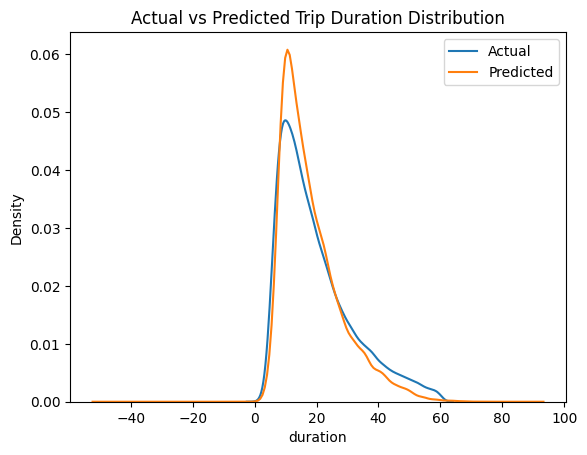

In [19]:
# Reload best model to visualize performance
with open("models/ridge.bin", "rb") as f_in:
    pipeline = pickle.load(f_in)

X_val = val_data[categorical + numerical]
y_val = val_data[target]
y_pred = pipeline.predict(X_val)

sns.kdeplot(y_val, label='Actual')
sns.kdeplot(y_pred, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Trip Duration Distribution")
plt.show()